In [1]:
import os
os.chdir('..')

# Packages

In [2]:
import datetime
data_datetime = datetime.datetime(2020, 4, 4)

In [3]:
from nlp import preprocessing

In [4]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import TruncatedSVD # SVD for sparse matrices
from sklearn.decomposition import PCA # SVD for sparse matrices
from sklearn.preprocessing import normalize # normalization for sparse matrices


# Read in Small Data (metadata)

In [5]:
metadata = pd.read_csv('big_data/metadata_20-04-03.csv')
metadata = metadata[pd.isnull(metadata['abstract']) == False].reset_index(drop=True)

C:\Users\vldoa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Using the search query to focus on abstracts:
**"COVID-19"** OR Coronavirus OR "Corona virus" OR **"2019-nCoV"** OR "SARS-CoV" OR "MERS-CoV" OR “Severe Acute Respiratory Syndrome” OR “Middle East Respiratory Syndrome” 

In [6]:
metadata = metadata[metadata['abstract'].str.lower().str.contains(
 "covid-19|coronavirus|coronavirus|corona virus|2019-ncov|sars-cov|mers-cov|severe acute respiratory syndrome|middle east respiratory syndrome|sars-cov-2") | 
     metadata['abstract'].str.contains("MERS")
     ]



In [7]:
len(metadata)

9959

In [8]:
count = sum(metadata['abstract'].str.contains('COVID|2019-nCoV|SARS-CoV-2'))
print('There are ' + str(count) + ' articles mentioning COVID.')

There are 2000 articles mentioning COVID.


In [9]:
covid_article_indexes = np.argwhere(np.array(metadata['abstract'].str.contains('COVID|2019-nCoV|SARS-CoV-2'))).T[0]
mers_article_indexes = np.argwhere(np.array(metadata['abstract'].str.contains('MER|middle east| Middle East'))).T[0]
sars_article_indexes = np.argwhere(np.array(metadata['abstract'].str.contains('SARS'))).T[0]

# Traditional ML

## Preprocessing

Preprocess text

In [10]:
t = time.time()
preprocessor = preprocessing.Preprocessor(metadata['abstract'])
preprocessor.preprocess(lemmatize=True, stopwords=['abstract'], min_token_length=3)
print(time.time() - t)

71.98048138618469


Preprocess for bigrams

In [11]:
preprocessor.get_bigrams_from_preprocessed()

Create key NLP objects for word counts

In [12]:
preprocessor.create_nlp_items_from_preprocessed_df(no_below=2, verbose=True)

dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
                                                             preprocessor.bow_corpus_,
                                                             preprocessor.tfidf_,
                                                             preprocessor.corpus_tfidf_,
                                                             preprocessor.tfidf_sparse_)

0 canin_coronavirus
1 common
2 competit_elisa
3 describ
4 direct
5 epitop
6 felin
7 peplom_protein
8 relat
9 tgev_prcv
10 util

 107194 unique words. 

22047 unique words after extremes filtered. 


Word 16 ("coronavirus") appears 3 time.
Word 24 ("genom") appears 3 time.
Word 34 ("replic") appears 2 time.
Word 36 ("role") appears 1 time.
Word 45 ("virus") appears 5 time.
Word 72 ("fusion") appears 1 time.
Word 89 ("recov") appears 2 time.
Word 97 ("strain") appears 1 time.
Word 107 ("appear") appears 1 time.
Word 132 ("sit") appears 1 time.
Word 143 ("follow") appears 2 time.
Word 149 ("initi") appears 1 time.
Word 158 ("protein") appears 1 time.
Word 168 ("compar") appears 1 time.
Word 218 ("potenti") appears 2 time.
Word 221 ("second") appears 1 time.
Word 224 ("show") appears 1 time.
Word 232 ("acid") appears 1 time.
Word 243 ("generat") appears 1 time.
Word 298 ("studi") appears 1 time.
Word 369 ("kinet") appears 1 time.
Word 371 ("level") appears 1 time.
Word 405 ("mutant") appea

## PCA

## Implementation

In [38]:
tfidf_sparse_norm = normalize(tfidf_sparse, norm='l1', axis=1)

[0.00202896 0.01195268 0.0090523  0.00762229 0.00595263 0.0047901
 0.00455875 0.00433169 0.00406272 0.00371116 0.0033649  0.00332745
 0.00320444 0.00314831 0.0030776  0.00301124 0.00299052 0.00284985
 0.00279215 0.0025793  0.00249166 0.00234675 0.00232751 0.00219495
 0.00210057 0.0020335  0.00200255 0.00196718 0.00194246 0.00190801
 0.00189306 0.00185269 0.0018128  0.0017708  0.00175477 0.00173285
 0.00171593 0.00166769 0.00165651 0.00165063 0.00161504 0.00158297
 0.00156555 0.00154175 0.00152455 0.00150045 0.00149035 0.00147104
 0.0014497  0.00143269 0.00140827 0.00139568 0.00137688 0.00136736
 0.00136369 0.00135384 0.00133875 0.00133427 0.00130652 0.00130119
 0.00129719 0.00127424 0.00127126 0.00125748 0.00124818 0.00123403
 0.00122052 0.00121082 0.00119342 0.00118876 0.00117723 0.00116783
 0.00116587 0.00114869 0.00113945 0.00112889 0.00112013 0.00109734
 0.00109214 0.00108395 0.00107937 0.00106093 0.00105579 0.00104777
 0.00103741 0.00102998 0.00102615 0.00101275 0.0010108  0.00100

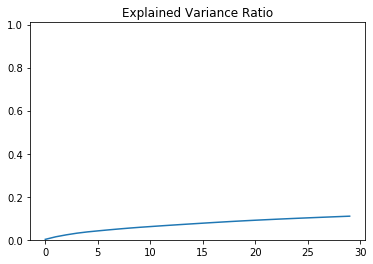

In [39]:
truncatedsvd = TruncatedSVD(n_components = 100, algorithm = 'randomized', random_state = 20)
pca = PCA(n_components = 100, svd_solver = 'randomized', random_state = 20)

transformed = truncatedsvd.fit_transform(tfidf_sparse_norm)
# transformed = truncatedsvd.fit_transform(tfidf_sparse)


plt.title('Explained Variance Ratio')
plt.plot(np.cumsum(truncatedsvd.explained_variance_ratio_)[0:30])
plt.ylim(0, 1.01)
print(truncatedsvd.explained_variance_ratio_)

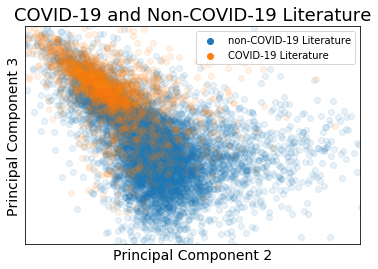

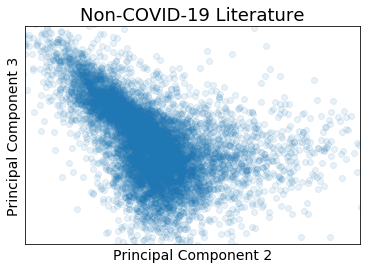

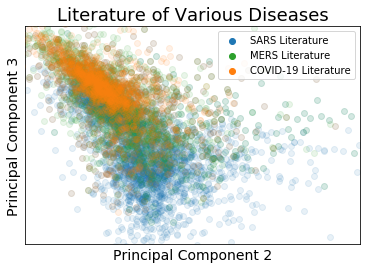

In [42]:
xscale_log_addition = 0.1
c_0, c_1 = 1, 2
#===== Set boundaries to remove outliers
f = 0.01 # dimension factor
p = 0.5 #percentile
width = np.percentile(transformed[:,c_0], 100 - p) - np.percentile(transformed[:,c_0], p)
height = np.percentile(transformed[:,c_1], 100 - p) - np.percentile(transformed[:,c_1], p)

left, right = np.percentile(transformed[:,c_0], p) - f * width, np.percentile(transformed[:,c_0], 100 - p) + f * width
low, high = np.percentile(transformed[:,c_1], p) - f * height, np.percentile(transformed[:,c_1], 100 - p) + f * height
#=====

not_covid = (np.isin(np.array(list(range(len(transformed)))), covid_article_indexes) == False)
plt.scatter(transformed[not_covid,c_0],
            transformed[not_covid,c_1], alpha=0.1, label='non-COVID-19 Literature')

plt.scatter(transformed[covid_article_indexes,c_0],
            transformed[covid_article_indexes,c_1], alpha=0.1, label='COVID-19 Literature')
# plt.yscale('log')
plt.xlim(left, right); plt.ylim(low, high)
# plt.xscale('log')
plt.title('COVID-19 and Non-COVID-19 Literature', size=18)
plt.xlabel('Principal Component ' + str(c_0 + 1), size=14)
plt.ylabel('Principal Component ' + str(c_1 + 1), size=14)
plt.xticks([]); plt.yticks([])
leg=plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()




not_covid = (np.isin(np.array(list(range(len(transformed)))), covid_article_indexes) == False)
plt.scatter(transformed[not_covid,c_0],
            transformed[not_covid,c_1], alpha=0.1, label='non-COVID-19 Literature')

plt.scatter(transformed[covid_article_indexes,c_0],
            transformed[covid_article_indexes,c_1], alpha=0., label='COVID-19 Literature')
# plt.yscale('log')
# plt.xscale('log')
plt.title('Non-COVID-19 Literature', size=18)
plt.xlabel('Principal Component ' + str(c_0 + 1), size=14)
plt.ylabel('Principal Component ' + str(c_1 + 1), size=14)
plt.xticks([]); plt.yticks([])
plt.xlim(left, right); plt.ylim(low, high)
# plt.legend()
plt.show()



plt.scatter(transformed[sars_article_indexes,c_0],
            transformed[sars_article_indexes,c_1], alpha=0.1, label='SARS Literature', zorder=1)
plt.scatter(transformed[mers_article_indexes,c_0],
            transformed[mers_article_indexes,c_1], alpha=0.1, label='MERS Literature', c='C2', zorder=2)
plt.scatter(transformed[covid_article_indexes,c_0],
            transformed[covid_article_indexes,c_1], alpha=0.1, label='COVID-19 Literature', c='C1', zorder=3)
# plt.yscale('log')
# plt.xscale('log')
plt.title('Literature of Various Diseases', size=18)
plt.xlabel('Principal Component ' + str(c_0 + 1), size=14)
plt.ylabel('Principal Component ' + str(c_1 + 1), size=14)
plt.xticks([]); plt.yticks([])
leg=plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlim(left, right); plt.ylim(low, high)
plt.show()

Identifying PCs that separate COVID/non-COVID literature

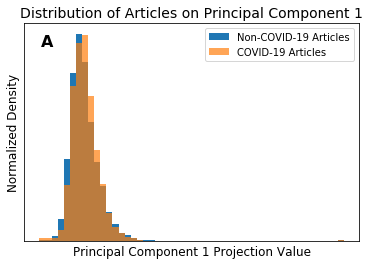

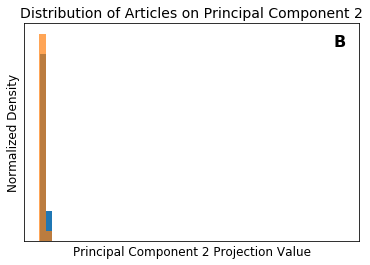

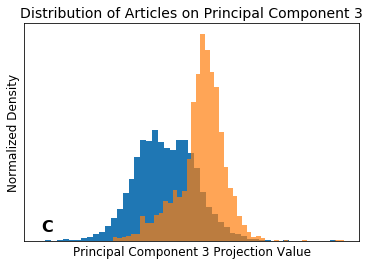

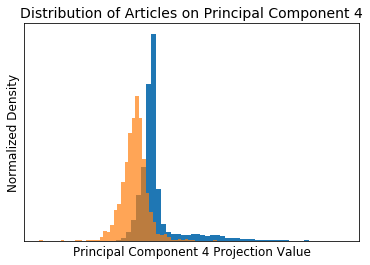

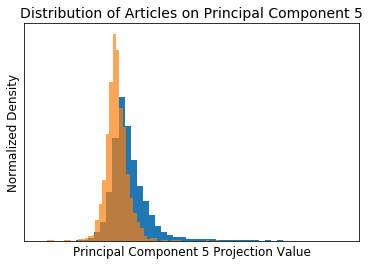

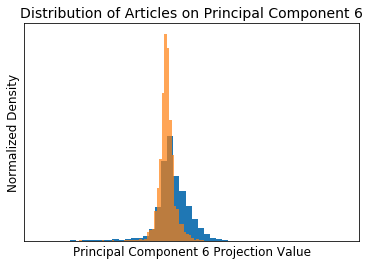

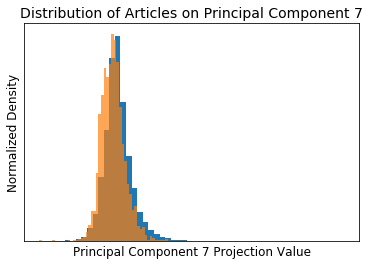

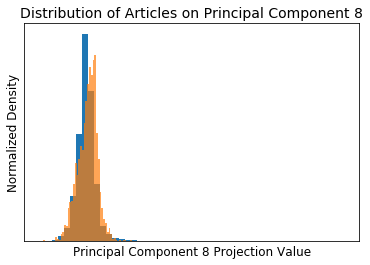

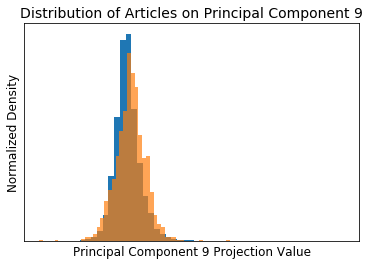

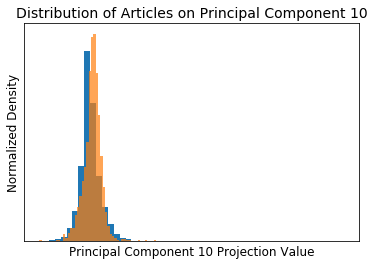

In [36]:
n_bins = 50

panel_set = [
    [0.05, 0.95, 'A'],
    [0.925, 0.95, 'B'],
    [0.05, 0.1, 'C'],
    [0.925, 0.1, 'D']
]


for c in range(10):
    fig, ax = plt.subplots()
    _, _, _ = plt.hist(transformed[np.setdiff1d(list(range(len(transformed))), covid_article_indexes), c]
             , density=True, alpha=1., bins=50, label='Non-COVID-19 Articles')
    _, _, _ = plt.hist(transformed[covid_article_indexes, c], density=True,
                       alpha=0.7, bins=50, label='COVID-19 Articles') 
    plt.title('Distribution of Articles on Principal Component ' + str(c + 1), size=14)
    plt.xticks([]); plt.yticks([])
    plt.ylabel('Normalized Density', size=12)
    plt.xlabel('Principal Component ' + str(c + 1) + ' Projection Value', size=12)
    
    if c < 3: # label & save only first few figs
        plt.text(panel_set[c][0], panel_set[c][1], panel_set[c][2],
                 transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')
        if c == 0:
            plt.legend()
        plt.savefig('Paper/Figures/1' + panel_set[c][2] + '.png', dpi=300)
    plt.show()
    
    


<IPython.core.display.Javascript object>


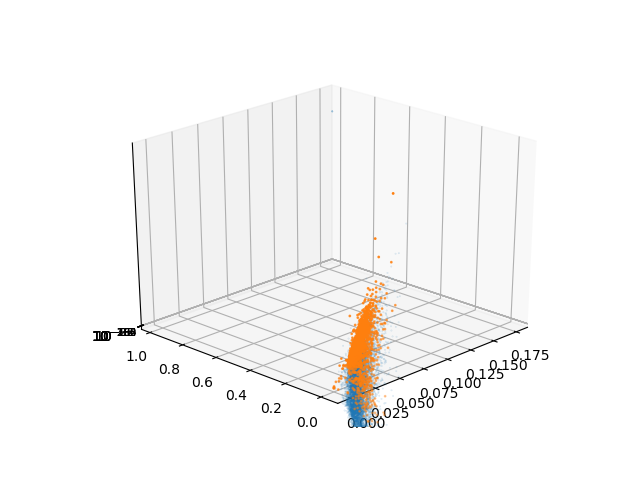

In [59]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook




import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(transformed[not_covid,0], transformed[not_covid,1], transformed[not_covid,2], s=0.1, alpha=0.2)
ax.scatter(transformed[covid_article_indexes,0], transformed[covid_article_indexes,1],
           transformed[covid_article_indexes,2], s=1)

# ax.xscale('log')
ax.set_zscale('log')
# ax.set_yscale('log')

## Analysis

In [17]:
def get_top_words_and_scores(svd, dictionary, c, n, visual=True):
    word_ids_sorted = np.argsort(np.abs(svd.components_[c]))[::-1]
    top_words_and_scores = [[dictionary[word_ids_sorted[i]], svd.components_[c, word_ids_sorted[i]]] for i in range(n)]
    top_words_and_scores = pd.DataFrame(
        top_words_and_scores,columns=['word', 'component_score']).sort_values('component_score')
    
    if visual:
        %matplotlib inline
        %matplotlib inline

        plt.figure(figsize=(18,5))
        plt.bar(height=top_words_and_scores['component_score'], x=top_words_and_scores['word'])
        plt.xticks(rotation=90, size=14)
        plt.xlabel("Lemmatized Term", size=16)
        plt.ylabel("Component " + str(c + 1) + ' Value', size=16)
        plt.title("Top " + str(n) + " Words' Values of Principal Component " + str(c+1), size=20)
        plt.show()
    
    
    return top_words_and_scores

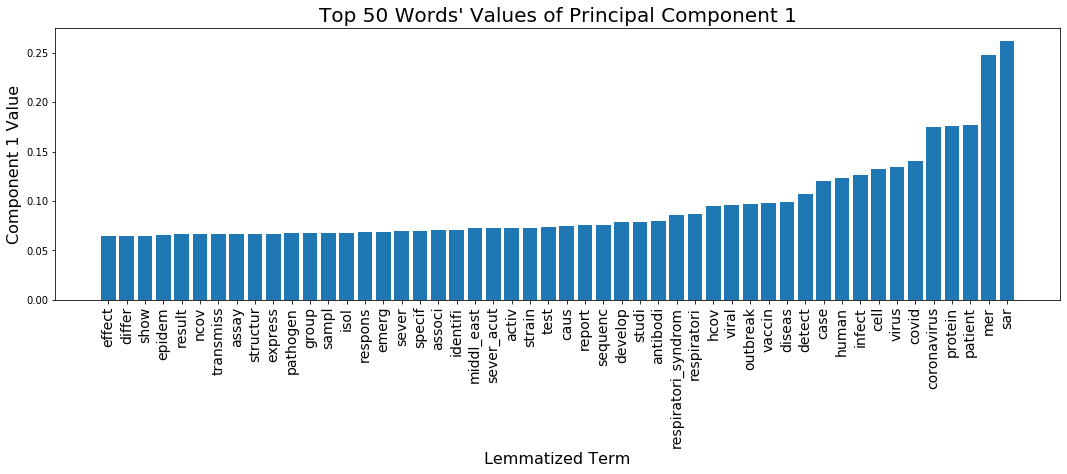

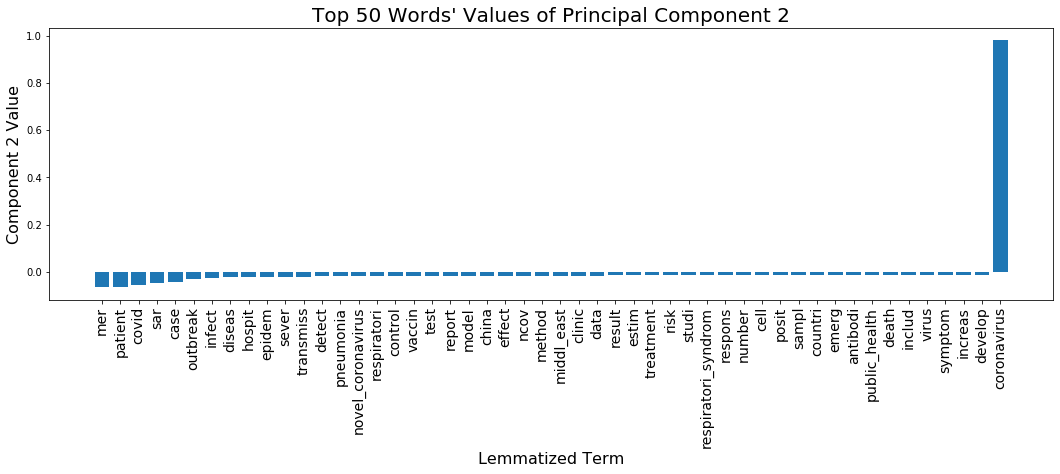

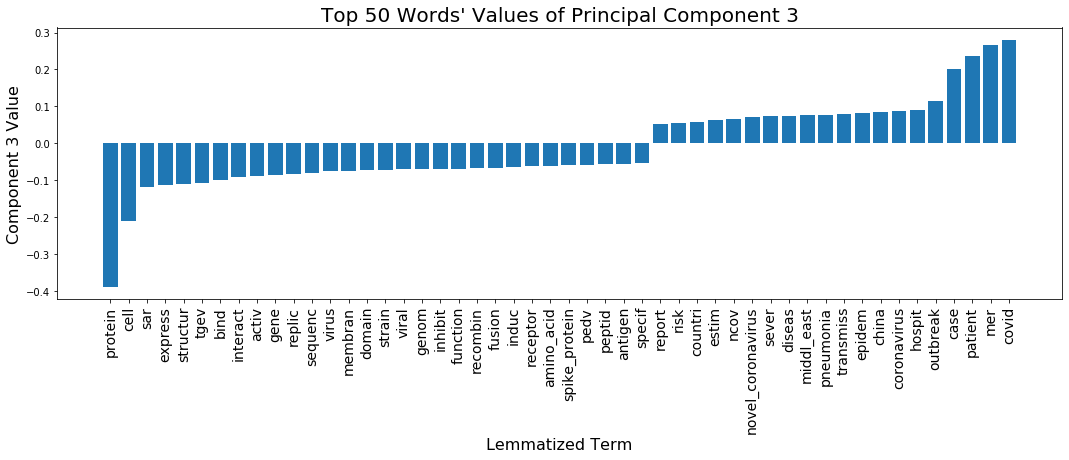

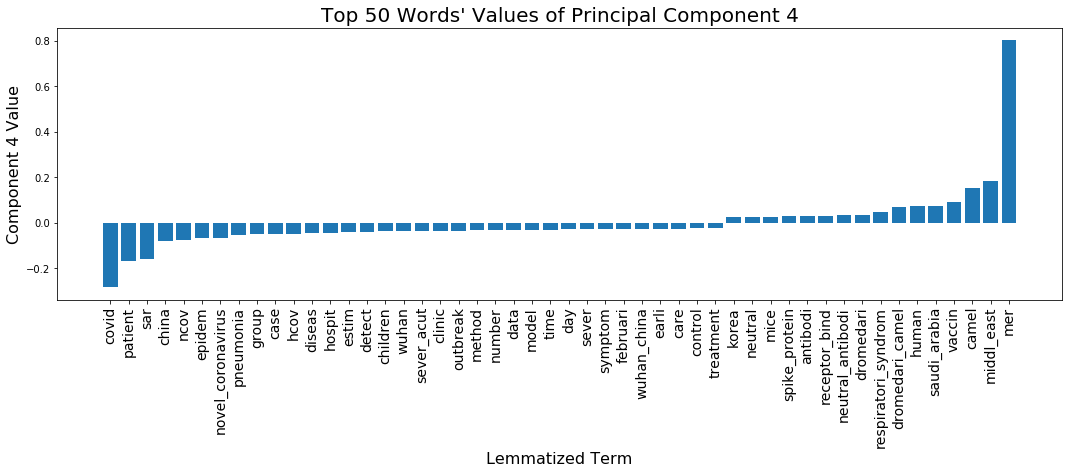

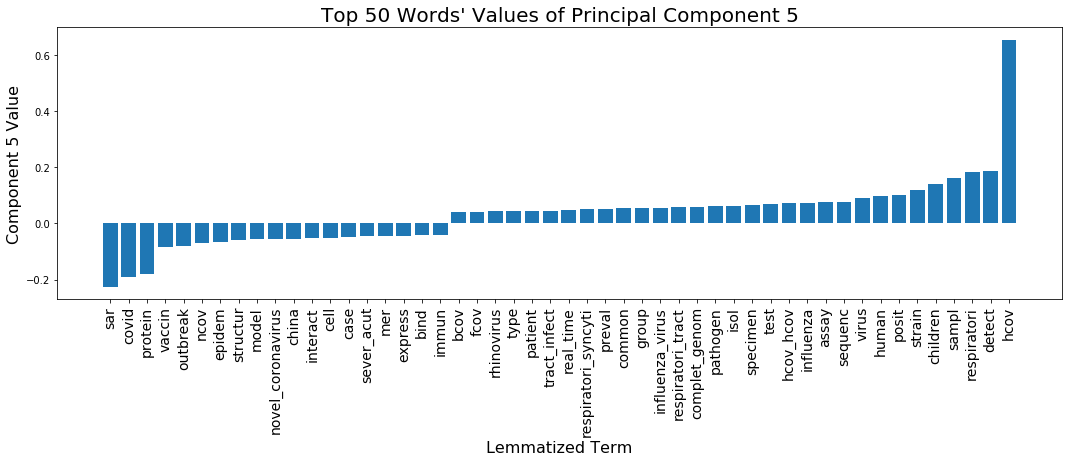

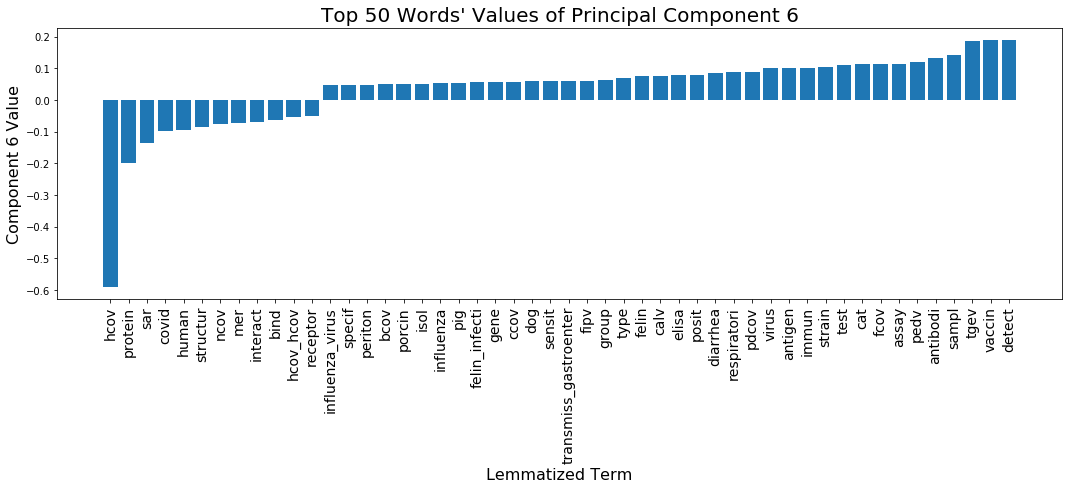

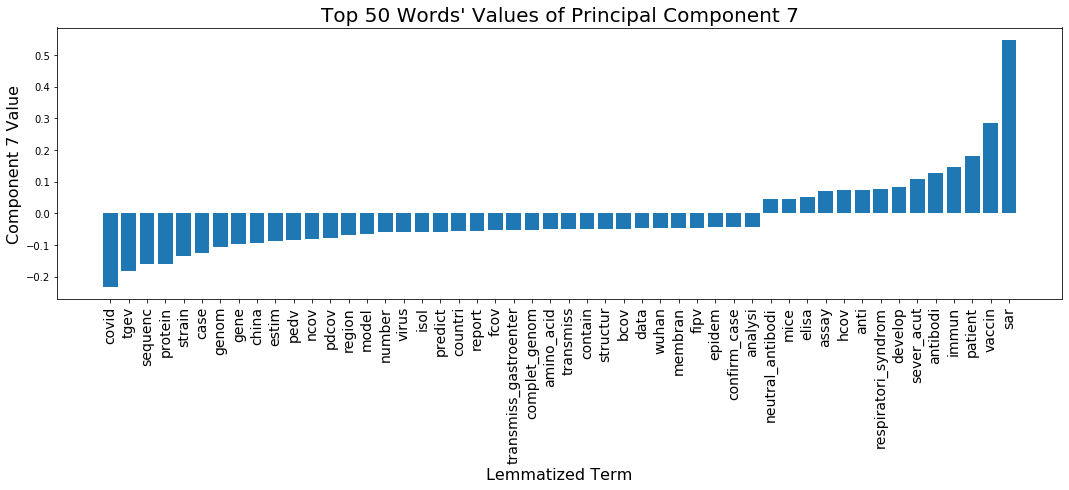

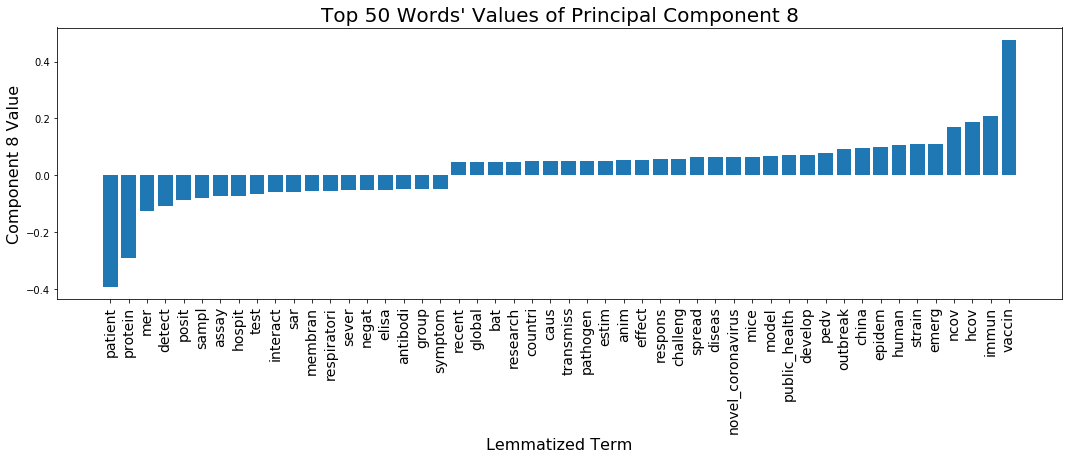

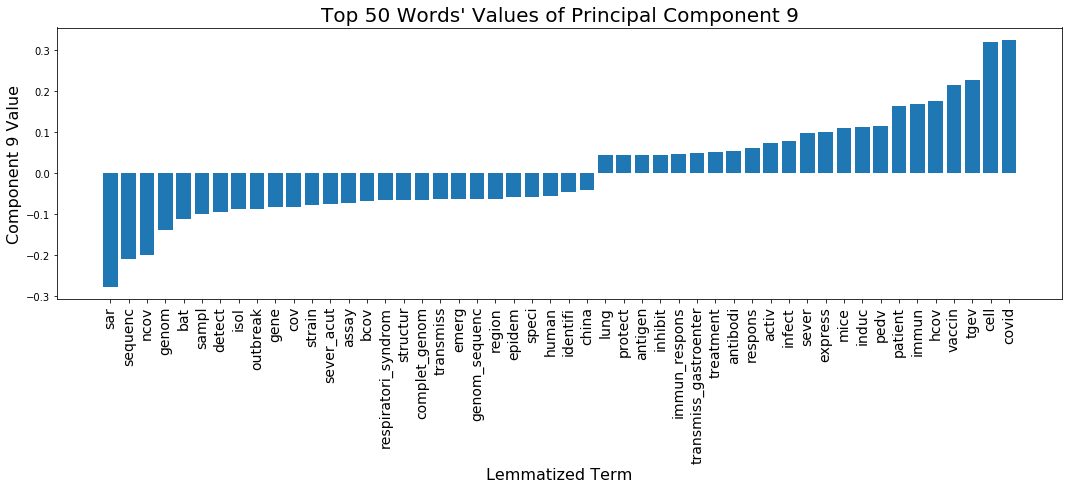

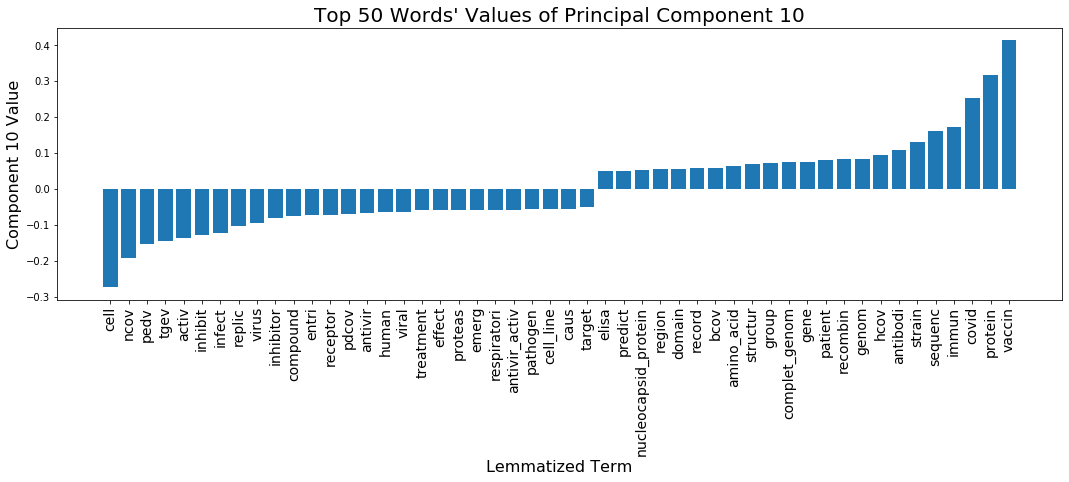

In [18]:
for i in range(10):
    top_words_and_scores = get_top_words_and_scores(truncatedsvd, dictionary, i, 50, visual=True)
    plt.show()

In [19]:
c_a, c_b = 2, 3

metadata['component_a'] = transformed[:,0] * 10**6
metadata['component_b'] = transformed[:,1] * 10**6

metadata['component_a_percentile'] = metadata['component_a'].rank(pct=True)
metadata['component_b_percentile'] = metadata['component_b'].rank(pct=True)

In [20]:
metadata['abstract_COVID'] = metadata['abstract'].str.contains('COVID')

Word analysis

In [21]:
covid_or_not = False
word = 'spike protein'

total = sum(metadata['abstract_COVID'] == covid_or_not)
total_subset = sum((metadata['abstract_COVID'] == covid_or_not) & (metadata['abstract'].str.lower().str.contains(word)))
print(total_subset / total)

0.05270588235294118


Automated word analysis including bigrams

In [41]:
c = c_b
total_covid = sum(metadata['abstract_COVID'] == True)
total_not_covid = sum(metadata['abstract_COVID'] == False)
word_analysis_df = copy.deepcopy(metadata[['abstract_COVID']])


word_list = get_top_words_and_scores(truncatedsvd, dictionary, c, 50, visual=False)
covid_pcts = []; not_covid_pcts = []
for word in word_list['word']:
    word_analysis_df['contains_word'] = [word in doc for doc in preprocessor.preprocessed_text_]

    total_subset = sum((word_analysis_df['abstract_COVID']) & (word_analysis_df['contains_word'] ))
    covid_pcts.append(round(total_subset / total_covid * 100, 1))
    total_subset = sum((word_analysis_df['abstract_COVID'] == False) & (word_analysis_df['contains_word'] ))
    not_covid_pcts.append(round(total_subset / total_not_covid * 100, 1))
    
word_analysis = pd.DataFrame(np.array([word_list['word'], word_list['component_score'], covid_pcts, not_covid_pcts]).T, 
                             columns = ['word', 'component_4_score','covid_pcts', 'not_covid_pcts'])
word_analysis
# word_analysis.to_csv('big_data/top-word-analysis-pc3.csv', index=False)

,word,component_4_score,covid_pcts,not_covid_pcts
0,covid,-0.28424,96.6,0.8
1,patient,-0.169143,47.8,21.1
2,sar,-0.160752,41.2,36.6
3,china,-0.0792984,33.3,6.5
4,ncov,-0.0774961,7.7,4.5
5,epidem,-0.0657347,28.7,9.3
6,novel_coronavirus,-0.0650056,27.3,7.2
7,pneumonia,-0.0543534,18.6,7.1
8,group,-0.0510571,12.3,11.7
9,case,-0.0507908,47.6,17.2


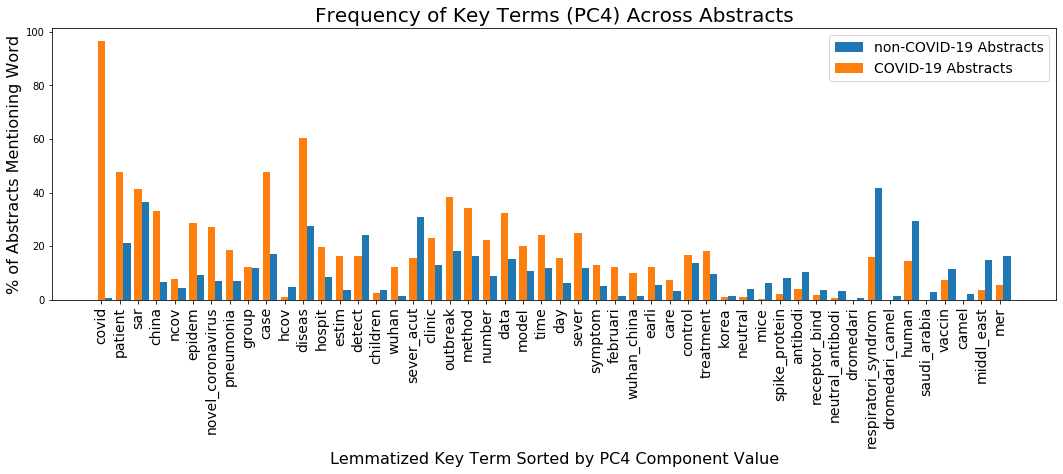

In [42]:
plt.figure(figsize=(18,5))


plt.bar(np.arange(len(word_analysis['word'])) + 0.4,
        word_analysis['not_covid_pcts'], 
        label='non-COVID-19 Abstracts', width=0.4)
plt.bar(np.arange(len(word_analysis['word'])),
        word_analysis['covid_pcts'], 
        label='COVID-19 Abstracts', width=0.4)
plt.xticks(np.arange(len(word_analysis['word'])), word_analysis['word'], rotation=90, size=14)
plt.xlabel('Lemmatized Key Term Sorted by PC4 Component Value', size=16)
plt.ylabel('% of Abstracts Mentioning Word', size=16)
plt.title('Frequency of Key Terms (PC4) Across Abstracts', size=20)
plt.legend(fontsize=14)
plt.show()


# plt.xlabel("Lemmatized Term", size=16)
# plt.ylabel("Component " + str(c + 1) + ' Value', size=16)
# plt.title("Top " + str(n) + " Words' Values of Principal Component " + str(c+1), size=20)
# plt.show()

Analysis of abstracts over time

In [20]:
metadata_dt_analysis = copy.deepcopy(metadata)

metadata_dt_analysis['converted_datetime'] = pd.to_datetime(metadata_dt_analysis['publish_time'], errors='coerce') # if format fails to parse, return NaT
metadata_dt_analysis = metadata_dt_analysis.sort_values('converted_datetime')
metadata_dt_analysis = metadata_dt_analysis[pd.isnull(metadata_dt_analysis['converted_datetime']) == False] # drop abstracts w/ null
metadata_dt_analysis = metadata_dt_analysis[metadata_dt_analysis['converted_datetime'] <= data_datetime] # drop those with impossible datetimes

In [21]:
# Key problems:
    # 2020 date times (~250 articles)
    # A couple of articles with no date time
    # A couple of articles with impossible date times

covid_abstracts = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]
covid_abstracts = covid_abstracts[covid_abstracts['converted_datetime'] > 
                                 datetime.datetime(2020, 1, 1)] # drop those with only '2020' as datetime

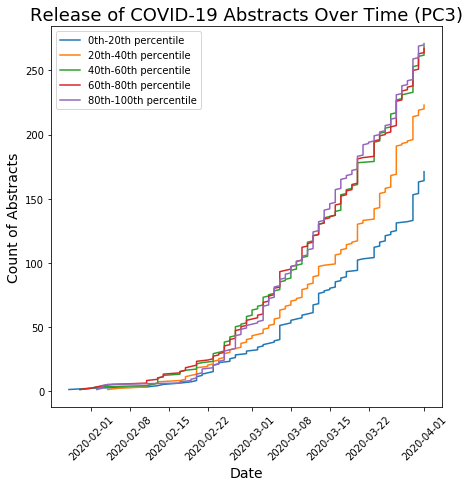

In [28]:
plt.figure(figsize=(7, 7))
for lower in np.array(list(range(5))) / 10 * 2:
    upper = lower + 0.2
    boolean = np.logical_and(covid_abstracts['component_a_percentile'] >= lower, 
                                            covid_abstracts['component_a_percentile'] <= upper)
    plt.plot(covid_abstracts[boolean]['converted_datetime'],
             np.cumsum(np.repeat(1, len(covid_abstracts[boolean]))),
             label=str(int(lower*100)) + 'th-' + str(int(upper*100)) + 'th percentile'
            )


plt.xticks(rotation=45)
plt.xlabel('Date', size=14)
plt.ylabel('Count of Abstracts', size=14)
plt.title('Release of COVID-19 Abstracts Over Time (PC3)', size=18)
# plt.yscale('log')
plt.legend()
plt.show()

Tracking rxiv articles over time (not peer reviewed stuff)

Text(0.5, 1.0, 'COVID Articles')

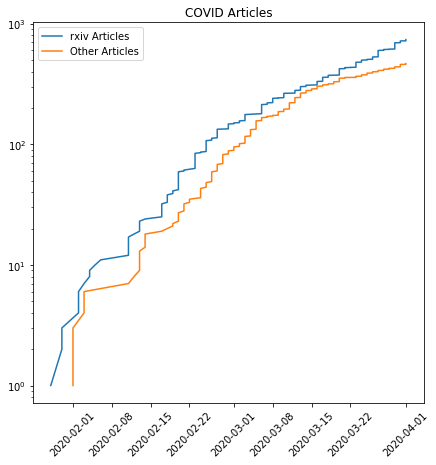

In [88]:
plt.figure(figsize=(7, 7))
boolean = covid_abstracts['source_x'].isin(['biorxiv', 'medrxiv'])
plt.plot(covid_abstracts[boolean]['converted_datetime'],
         np.cumsum(np.repeat(1, len(covid_abstracts[boolean]))), label='rxiv Articles'
        )
boolean = boolean == False
plt.plot(covid_abstracts[boolean]['converted_datetime'],
         np.cumsum(np.repeat(1, len(covid_abstracts[boolean]))), label='Other Articles'
        )

plt.xticks(rotation=45)
plt.yscale('log')
plt.legend()
plt.title('COVID Articles')

Text(0.5, 1.0, 'Non-COVID Articles')

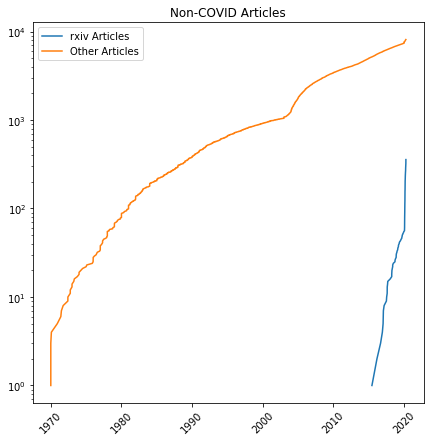

In [89]:
plt.figure(figsize=(7, 7))
non_covid_abstracts = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID'] == False]

boolean = non_covid_abstracts['source_x'].isin(['biorxiv', 'medrxiv'])
plt.plot(non_covid_abstracts[boolean]['converted_datetime'],
         np.cumsum(np.repeat(1, len(non_covid_abstracts[boolean]))), label='rxiv Articles'
        )
boolean = boolean == False
plt.plot(non_covid_abstracts[boolean]['converted_datetime'],
         np.cumsum(np.repeat(1, len(non_covid_abstracts[boolean]))), label='Other Articles'
        )

plt.xticks(rotation=45)
plt.yscale('log')
plt.legend()
plt.title('Non-COVID Articles')

# Write to file

In [40]:
metadata.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_pdf_parse',
       'has_pmc_xml_parse', 'full_text_file', 'url', 'component_a',
       'component_b', 'component_a_percentile', 'component_b_percentile',
       'abstract_COVID'],
      dtype='object')

In [41]:
metadata_small = metadata[[
    'title', 'doi', 'pmcid', 'pubmed_id', 'abstract', 'publish_time', 'journal', 
    
    'component_a', 'component_b', 'component_a_percentile', 'component_b_percentile', 'abstract_COVID'
]]
metadata_small.to_csv('big_data/metadata_PCAed_subsetted', sep='|', index=False)

In [42]:
metadata_small

,title,doi,pmcid,pubmed_id,abstract,publish_time,journal,component_a,component_b,component_a_percentile,component_b_percentile,abstract_COVID
27,An ELISA for the detection of serum antibodies...,10.1016/0007-1935(91)90010-k,NaN,1717102.0,Abstract A competition ELISA utilizing a mAb d...,1991-08-31,British Veterinary Journal,14200.138057,-1691.775576,0.029722,0.620645,False
29,Equine arteritis virus: An overview,10.1016/0007-1935(92)90044-2,NaN,1319787.0,Abstract The causative agent of the respirator...,1992-06-30,British Veterinary Journal,24151.037390,-847.255219,0.461291,0.720755,False
33,Morphology and morphogenesis of a coronavirus ...,10.1016/0014-4800(76)90045-9,NaN,187445.0,Abstract The morphology and morphogenesis of v...,1976-12-31,Experimental and Molecular Pathology,14844.285255,-631.259247,0.037654,0.743850,False
37,Bovine coronavirus antigen in the host cell pl...,10.1016/0014-4800(90)90039-g,NaN,2261945.0,Abstract Expression of bovine coronavirus (BCV...,1990-10-31,Experimental and Molecular Pathology,23744.371183,-2334.723945,0.437393,0.544231,False
44,Endosomal association of a protein phosphatase...,10.1016/0014-5793(91)80528-b,NaN,1674698.0,Abstract On the assumption that dephosphorylat...,1991-05-06,FEBS Letters,18611.410004,406.048850,0.148107,0.835927,False
45,Putative papain-related thiol proteases of pos...,10.1016/0014-5793(91)81034-6,NaN,1652473.0,Abstract A computer-assisted comparative analy...,1991-08-19,FEBS Letters,24843.628572,321.154839,0.502761,0.828898,False
51,Influence of coronavirus (transmissible gastro...,10.1016/0016-5085(84)90717-0,NaN,6735081.0,Abstract Four silver—silver chloride electrode...,1984-08-31,Gastroenterology,16989.238183,-937.905451,0.087559,0.709509,False
57,An in-depth study of Crohn's disease in two Fr...,10.1016/0016-5085(93)90401-w,NaN,8425677.0,Abstract Background: Two French families were ...,1993-02-28,Gastroenterology,20415.724289,-2054.685672,0.239381,0.575459,False
67,The pathogenesis of nephritis in chickens indu...,10.1016/0021-9975(82)90078-0,NaN,6282945.0,Abstract Nephritis in chickens caused by infec...,1982-04-30,Journal of Comparative Pathology,17224.814409,-734.085184,0.094789,0.732001,False
76,Pathogenicity and antigen detection of the Nou...,10.1016/0021-9975(92)90068-6,NaN,1313460.0,Abstract We compared the pathogenicity and the...,1992-01-31,Journal of Comparative Pathology,14886.477126,196.798081,0.038558,0.819460,False
